<a href="https://colab.research.google.com/github/khanhvy31/Classification_Imbalance_Tutorial/blob/main/Insurance_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import All important packages


In [1]:
# import packages
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder

In [2]:
# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture
!pip install kaggle

In [4]:
# Create the kaggle directory and
# (NOTE: Do NOT run this cell more than once unless restarting kernel)
!mkdir ~/.kaggle

In [5]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [6]:
# Download dataset
!!kaggle datasets download -d annantkumarsingh/health-insurance-cross-sell-prediction-data

['Dataset URL: https://www.kaggle.com/datasets/annantkumarsingh/health-insurance-cross-sell-prediction-data',
 'License(s): CC0-1.0',
 'Downloading health-insurance-cross-sell-prediction-data.zip to /content',
 '',
 '  0% 0.00/6.20M [00:00<?, ?B/s]',
 ' 81% 5.00M/6.20M [00:00<00:00, 51.1MB/s]',
 '',
 '100% 6.20M/6.20M [00:00<00:00, 60.0MB/s]']

In [7]:
# Unzip folder in Colab content folder
!unzip /content/health-insurance-cross-sell-prediction-data.zip

Archive:  /content/health-insurance-cross-sell-prediction-data.zip
  inflating: test.csv                
  inflating: train.csv               


# EDA & Preprocessing

This tutorial will focus on the machine learning end-to-end pipeline, therefore, we will skim through the EDA part. See EDA Part separately here

In [8]:
df = pd.read_csv("train.csv")

In [9]:
df.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
5,6,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176,0
6,7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0
7,8,Female,56,1,28.0,0,1-2 Year,Yes,32031.0,26.0,72,1
8,9,Female,24,1,3.0,1,< 1 Year,No,27619.0,152.0,28,0
9,10,Female,32,1,6.0,1,< 1 Year,No,28771.0,152.0,80,0


In [28]:
#check null
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Annual_Premium        381109 non-null  float64
 6   Policy_Sales_Channel  381109 non-null  float64
 7   Vintage               381109 non-null  int64  
 8   Response              381109 non-null  int64  
 9   Gender_Female         381109 non-null  int64  
 10  Gender_Male           381109 non-null  int64  
 11  Vehicle_Damage_No     381109 non-null  int64  
 12  Vehicle_Damage_Yes    381109 non-null  int64  
 13  encoded_vehical_age   381109 non-null  float64
dtypes: float64(4), int64(10)
memory usage: 40.7 MB


<ipython-input-31-8b8e6d44cf2e>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Annual_Premium'])


<Axes: xlabel='Annual_Premium', ylabel='Density'>

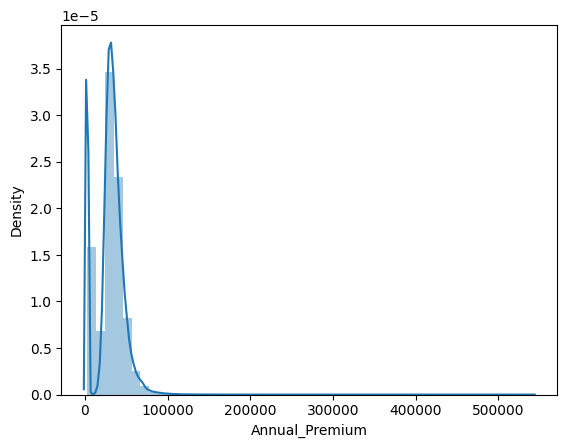

In [31]:
#what is the distribution of annual premium?
sns.distplot(df['Annual_Premium'])

<Axes: ylabel='Annual_Premium'>

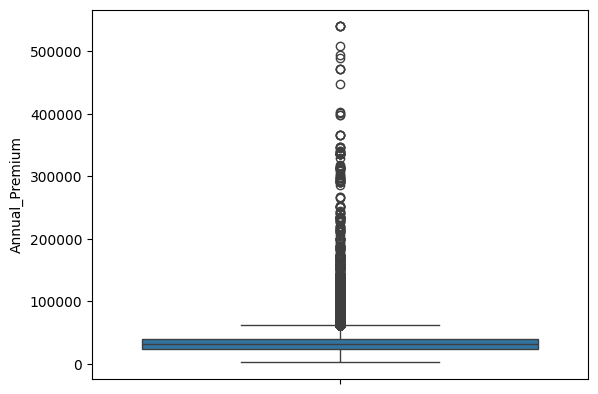

In [35]:
#check outlier
sns.boxplot(df['Annual_Premium'])

In [10]:
#turn Gender, Vehical Damage to dummy variable
df = pd.get_dummies(df, columns = ['Gender','Vehicle_Damage'],dtype = int)

In [11]:
#turn vehical_age to ordinal feature
enc = OrdinalEncoder()
df['encoded_vehical_age'] = enc.fit_transform(df[['Vehicle_Age']])

In [12]:
df.drop(columns = 'Vehicle_Age',inplace = True)

# Check Balance of target variable

<Axes: ylabel='count'>

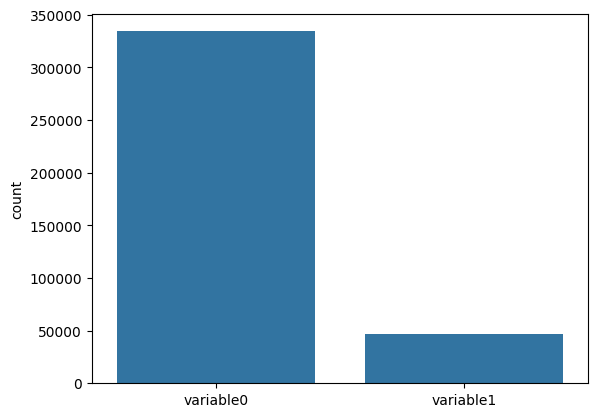

In [13]:
variable1 = df['Response'].sum()
variable0 = df['Response'].count() - df['Response'].sum()
sns.barplot(x = ['variable0','variable1'], y = df['Response'].value_counts())

In [14]:
#Calculate the %of variable 0 compare to variable 1
pct_variable =  variable0/(df['Response'].count())*100
print(f'percentage of variable 0: {pct_variable}')

percentage of variable 0: 87.74366388618479


The model will easily achieve 87.7% of accuracy by always predicting 0

# Train Test Split

There are a couple of reasons why we want to split before we balance the target. We want to work on training set ONLY. Test set should be **always** set aside as it will represent for our "outsample" which in real life, we haven't seen before

In [15]:
features = df.drop(columns = 'Response')
label = df['Response']

In [16]:
seed = 42
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=seed)

##Undersampling

In [17]:
#randomly undersampling
#load library
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42) #reproducebility
x_train_rus, y_train_rus = rus.fit_resample(x_train, y_train)
print(x_train_rus.shape)
print(y_train_rus.shape)

(74374, 13)
(74374,)


## Randomly oversampling

In [18]:
#randomly oversampling
#load library
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42) #reproducebility
x_train_ros, y_train_ros = ros.fit_resample(x_train, y_train)
print(x_train_ros.shape)
print(y_train_ros.shape)

(535400, 13)
(535400,)


<Axes: ylabel='count'>

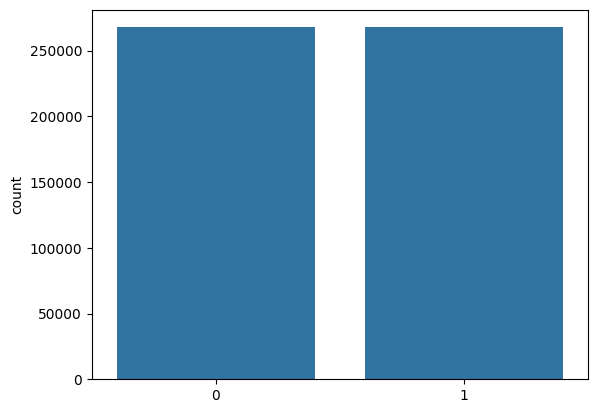

In [19]:
#double check the count of each variable again
sns.barplot(x = ['0','1'], y = y_train_ros.value_counts())

#Using Smote


In [20]:
from imblearn.over_sampling import SMOTE
from collections import Counter

counter = Counter(y_train)
print('Before', counter)

# oversampling the train dataset using SMOTE
smt = SMOTE()
x_train_sm, y_train_sm = smt.fit_resample(x_train, y_train)

counter = Counter(y_train_sm)
print('After', counter)

Before Counter({0: 267700, 1: 37187})
After Counter({1: 267700, 0: 267700})


# Model Selection with balanced dataset

### Set a baseline

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
log_reg = LogisticRegression()
log_reg.fit(x_train_sm, y_train_sm)
#use the model to predict
y_pred = log_reg.predict(x_test)
train_accuracy = log_reg.score(x_train_sm, y_train_sm)
#Find the accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(test_accuracy)

0.6786754480333762


In [22]:
y_train_sm = np.array(y_train_sm).reshape(-1,1)

In [23]:
y_train_sm.shape

(535400, 1)

In [24]:
x_train_sm.shape

(535400, 13)

In [25]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train_sm, y_train_sm)
y_pred = dt.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(test_accuracy) #knowing that decision tree is tend to overfitting

0.8182152134554328


In [26]:
from sklearn.ensemble import RandomForestClassifier
dt = RandomForestClassifier()
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(test_accuracy) #knowing that decision tree is tend to overfitting

0.8705360657028155


In [27]:
import xgboost as xgb
xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(x_train,y_train)
y_pred = xgb_cl.predict(x_test)
train_scores = xgb_cl.score(x_train,y_train)
# Score
test_score = accuracy_score(y_test, y_pred)
print(test_score)

0.8745506546666317


# Metrics

We can choose accuracy score since we already balance the target variable. However, choosing F1 score or precision and recall will help us have a better idea on false positive and flase negative

# Hyperparameters Tuning

## Cross Validation - pros and con

# Random Search

## Optuna

#Post Production/ Monitoring